In [1]:
from models.mnist_classifier.lenet import LeNet5, LeNet1
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
import random
import os
from  PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms,utils,datasets
import numpy as np
from torch import optim
import time
import torchvision.models as models
from pylab import *

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
data_root = './autodl-tmp/mnist'
data_train = MNIST(data_root,
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))]))
data_test = MNIST(data_root,
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))]))

In [3]:
len(data_train)

60000

In [4]:
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=256, num_workers=8)

In [5]:
net = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)  #学习率，太高如2e-3会立马收敛，cagfuzz里设置为0.05

In [6]:
epoch = 100

In [7]:
def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    total_correct = 0
    for i, (images, labels) in enumerate(data_train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()
        # if i % 10 == 0:
            # print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))
        loss.backward()
        optimizer.step()
    avg_loss = sum(loss_list) / len(loss_list)
    acc = float(total_correct) / len(data_train)
    print('Train Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [8]:
def test():
    net.eval()
    batch_list = []
    with torch.no_grad():
        total_correct = 0
        avg_loss = 0.0
        for i, (images, labels) in enumerate(data_test_loader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            avg_loss += criterion(output, labels).sum()
            pred = output.detach().max(1)[1]
            total_correct += pred.eq(labels.view_as(pred)).sum()
            batch_list.append(i+1)

    avg_loss /= batch_list[-1]
    avg_loss = avg_loss.detach().cpu().item()
    acc = float(total_correct) / len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [9]:
def train_and_test(epoch):
    print('training...')
    acc, loss = train(epoch)
    val_acc, val_loss = test()
    return acc, loss, val_acc, val_loss

In [10]:
acc, loss, val_acc, val_loss = [], [], [], []
start = time.time()
for e in range(epoch):
    a, b, c, d = train_and_test(e)
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)
    print(f'lenet_epoch={e} test_acc={c:0.3f}')
    if e % 10 == 0:
        torch.save(net.state_dict(), f'autodl-tmp/save_model/mnist/Lenet5/epoch={e}_test_acc={c:0.3f}.pth')
end = time.time()
# 计算并打印输出你的训练时间
print("total time:{}".format(end - start))

training...
Train Avg. Loss: 1.588792, Accuracy: 0.558233
Test Avg. Loss: 0.559059, Accuracy: 0.854100
lenet_epoch=0 test_acc=0.854
training...
Train Avg. Loss: 0.422627, Accuracy: 0.882633
Test Avg. Loss: 0.313184, Accuracy: 0.910600
lenet_epoch=1 test_acc=0.911
training...
Train Avg. Loss: 0.297132, Accuracy: 0.914117
Test Avg. Loss: 0.250896, Accuracy: 0.925700
lenet_epoch=2 test_acc=0.926
training...
Train Avg. Loss: 0.247160, Accuracy: 0.927417
Test Avg. Loss: 0.209157, Accuracy: 0.937000
lenet_epoch=3 test_acc=0.937
training...
Train Avg. Loss: 0.213794, Accuracy: 0.936717
Test Avg. Loss: 0.183659, Accuracy: 0.942700
lenet_epoch=4 test_acc=0.943
training...
Train Avg. Loss: 0.190010, Accuracy: 0.942667
Test Avg. Loss: 0.165248, Accuracy: 0.949000
lenet_epoch=5 test_acc=0.949
training...
Train Avg. Loss: 0.169891, Accuracy: 0.949150
Test Avg. Loss: 0.148223, Accuracy: 0.953100
lenet_epoch=6 test_acc=0.953
training...
Train Avg. Loss: 0.154969, Accuracy: 0.952933
Test Avg. Loss: 0.

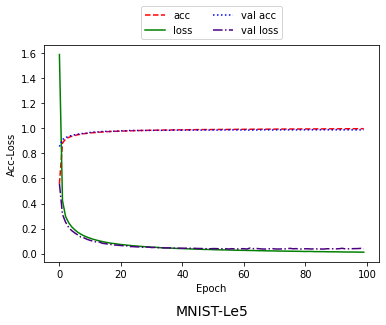

In [11]:
x = np.arange(epoch)
plt.plot(x, acc, color='red', linestyle='--', label="acc")
plt.plot(x, loss, color='green', label="loss")
plt.plot(x, val_acc, color='blue', linestyle='dotted', label="val acc")
plt.plot(x, val_loss, color='indigo', linestyle='dashdot', label="val loss")
plt.title('MNIST-Le5', fontsize=14, y=-0.27)
plt.xlabel('Epoch')
plt.ylabel('Acc-Loss')
plt.xticks(ticks=[0,20,40,60,80,100])
# 添加图例
plt.legend(loc='center',bbox_to_anchor=(0.5, 1.1),ncol=2)
plt.show()

In [12]:
val_acc

[0.8541,
 0.9106,
 0.9257,
 0.937,
 0.9427,
 0.949,
 0.9531,
 0.9582,
 0.9585,
 0.961,
 0.9672,
 0.97,
 0.9707,
 0.9712,
 0.975,
 0.9757,
 0.9744,
 0.9758,
 0.9769,
 0.9776,
 0.9804,
 0.9791,
 0.9807,
 0.9826,
 0.9828,
 0.9829,
 0.9825,
 0.9831,
 0.9831,
 0.9828,
 0.9846,
 0.9836,
 0.9842,
 0.9836,
 0.9853,
 0.9833,
 0.9848,
 0.9856,
 0.9858,
 0.986,
 0.9846,
 0.9861,
 0.9852,
 0.9865,
 0.9859,
 0.986,
 0.9859,
 0.9871,
 0.9866,
 0.9863,
 0.9867,
 0.9859,
 0.9866,
 0.9865,
 0.9868,
 0.9874,
 0.9875,
 0.9874,
 0.9868,
 0.9867,
 0.9858,
 0.988,
 0.9846,
 0.9863,
 0.9867,
 0.9877,
 0.9875,
 0.9883,
 0.9879,
 0.9863,
 0.9874,
 0.988,
 0.9877,
 0.9878,
 0.9882,
 0.9868,
 0.9878,
 0.9873,
 0.9884,
 0.9877,
 0.9877,
 0.9878,
 0.9883,
 0.9878,
 0.9881,
 0.988,
 0.9886,
 0.9882,
 0.988,
 0.9878,
 0.9879,
 0.9879,
 0.9875,
 0.9884,
 0.988,
 0.9877,
 0.9873,
 0.9877,
 0.9874,
 0.9887]

In [13]:
val_loss

[0.5590590834617615,
 0.3131835162639618,
 0.250896155834198,
 0.20915654301643372,
 0.18365900218486786,
 0.16524778306484222,
 0.14822295308113098,
 0.13215920329093933,
 0.12591686844825745,
 0.11420904844999313,
 0.10591620206832886,
 0.09876891225576401,
 0.09323614835739136,
 0.09252535551786423,
 0.08242050558328629,
 0.07916395366191864,
 0.07577147334814072,
 0.07223574072122574,
 0.06880929321050644,
 0.06734325736761093,
 0.06446841359138489,
 0.06297617405653,
 0.06199585273861885,
 0.05646151304244995,
 0.05587604269385338,
 0.05409560725092888,
 0.05341372638940811,
 0.05070337653160095,
 0.05162894353270531,
 0.052844591438770294,
 0.048318974673748016,
 0.049920499324798584,
 0.047917161136865616,
 0.047882385551929474,
 0.045585040003061295,
 0.045793309807777405,
 0.04587239399552345,
 0.043660666793584824,
 0.04270282760262489,
 0.04377833008766174,
 0.043095629662275314,
 0.043050941079854965,
 0.04349342733621597,
 0.04198816046118736,
 0.04242704436182976,
 0.0411

In [14]:
acc

[0.5582333333333334,
 0.8826333333333334,
 0.9141166666666667,
 0.9274166666666667,
 0.9367166666666666,
 0.9426666666666667,
 0.94915,
 0.9529333333333333,
 0.9573666666666667,
 0.9603166666666667,
 0.96335,
 0.9652666666666667,
 0.9673666666666667,
 0.9691,
 0.9710166666666666,
 0.9725166666666667,
 0.9738666666666667,
 0.9753666666666667,
 0.9761833333333333,
 0.9772,
 0.9781,
 0.9784666666666667,
 0.9796666666666667,
 0.9801666666666666,
 0.9809166666666667,
 0.9814333333333334,
 0.9823833333333334,
 0.9828666666666667,
 0.98315,
 0.98415,
 0.9847333333333333,
 0.9848333333333333,
 0.9851833333333333,
 0.9856333333333334,
 0.9862333333333333,
 0.98605,
 0.98665,
 0.9870666666666666,
 0.9874,
 0.9878333333333333,
 0.98785,
 0.9881833333333333,
 0.9886333333333334,
 0.9888333333333333,
 0.98915,
 0.9895666666666667,
 0.9895333333333334,
 0.9901,
 0.9899833333333333,
 0.9901833333333333,
 0.9901666666666666,
 0.99085,
 0.9909333333333333,
 0.9912333333333333,
 0.99095,
 0.991183333333

In [15]:
loss

[1.5887917358824548,
 0.4226273990691976,
 0.2971320406553593,
 0.24716042232640245,
 0.2137935958327131,
 0.19000963571857898,
 0.16989117914691884,
 0.15496935500426495,
 0.14206052143523035,
 0.13146855049627892,
 0.12291086978734808,
 0.11441041679775461,
 0.1079678753272016,
 0.10183638530050186,
 0.0961068849138757,
 0.0910149411159627,
 0.08666795991519664,
 0.08245688431916084,
 0.07967580990429889,
 0.07612643338581349,
 0.07256779712723925,
 0.07066943583653328,
 0.06737217448968837,
 0.06519507622306651,
 0.0626358069558727,
 0.0611150790838168,
 0.05854339605950295,
 0.05681018280063538,
 0.05479140882875691,
 0.05326263269290645,
 0.05173872383113237,
 0.050564803987582944,
 0.04917993100478928,
 0.04710660845913151,
 0.04637090069182376,
 0.045057052643375194,
 0.04429696083782201,
 0.04317708435131514,
 0.041684315195108984,
 0.041118945349800456,
 0.04009168202929357,
 0.03922292687632936,
 0.038216815942383194,
 0.036935308244713444,
 0.036514640631193813,
 0.035482984